# BACKGROUND

### In this project, I developed a self-driving program for the videogame GTA 5 using a recurrent LSTM model. My motivations for this project were twofold: I wanted to study machine learning techniques related to robotics, and furthermore, my province in Canada was locked down due to the pandemic, so of course I became extremely bored. Playing videogames in itself isn't productive in the longterm, but I wondered whether they could prove useful as a kind of basic physics simulation for developing deep learning models related to robotics. I defer the answer to that question to the judgment of anyone reading this!



### APPROACH: A keylogger in a separate program generates keypress data related to what direction the user intends to go ('w', 's', 'd', 'a') which is then fed into a recurrent neural network for training as the user is driving. This process of collecting data from the game while training the model in real time requires the use of multithreading, so there is a thread to train the model, and a thread to record keypresses. 

### Should the user need to go AFK, they simply push 'q' on their keyboard and then the program will exit the training loop and begin making predictions based on recent training data. While you are getting up to grab an extra bottle of gamerfuel (Mountain Dew), the neural network will take over and drive your car for you for the brief time window that you're absent. 

### There are two implementations: Space-dependent and space-independent. The space independent model, our LSTM by itself, will make predictions solely based on time-series data from user keypresses; the space-dependent model, however, contains a CNN-architecture that enables behavioural cloning on the data. This method was inspired by a Google research paper produced at the University of Texas at Austin, which combined CNN's with LSTM's to allow for behavioural cloning implemented with drones following a footpath in a public park. To deal with traffic in a game such as GTA 5 or Forza, a Yolov5 model may be preferable for the purposes of identifying the position of vehicles onscreen in screenspace, and then infering their physical position in world space in 3 dimensions. However, if you're going for a liesurely, scenic drive on the outskirts of Los Santos, then you probably wouldn't need to worry too much about traffic, and CNN's would suffice.

### For the case of navigating a relatively empty road using a CNN architecture, I posited that in training the data, you use a Hough transform on the screenspace images to identify road edges, and then use a single channel CNN binary classifier (y = 1 is 'Drive' and y = 0 is 'Stop'). The model I've devised calculates the conditional probability that the car should choose a given course of action given the probability of whether it continues to drive or stops, as per Baye's Theorem

#### P(key_press) = P(key_press | continues_driving)P(continues_driving)

### where the RHS could be rewritten as

### LSTM_predictions * CNN_prediction


### The prediction with the largest probability becomes the choice made by the space-dependent model.

# Applications to Financial Quantitative Analysis


### Being a physicist by training, the first thing I noticed in developing 3D plots of my data is how eerily similar the trajectory of the space-independent self-driving model was to 3D plots of Geometric Brownian motion! As a primer, we could for instance model the path in 3D space of a dust particle with Brownian motion, as well as stock and cryptocurrency prices. This is because both dust particles and financial forecasts, as well as self-driving models apparently, are subject to the laws of stochastic calculus. It may be well worth comparing this deep learning model to a purely pen-and-paper one to see whether this is true, and if so whether behavioural cloning methods in general can be approximated by continuous martingales.

### It goes without saying, I will continue to use recurrent LSTM's in conjunction with stochastic calculus and statistics to make predictions about the markets to sate my curiosity, and possibly to make some money ;)

In [8]:
#3D Plots
from mpl_toolkits import mplot3d  
# from nsepy import get_history as gh
import datetime as dt
from datetime import date
from matplotlib import pyplot as plt
from IPython.display import clear_output

In [7]:
import warnings
import numpy as np
import pandas as pd

#Data Preprocessing
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
#Time Series Machine Learning Based
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout  
from keras.models import Sequential 
import tensorflow as tf
#Discrete
import random

# One dimensional Model

### We'll build a 1D model as proof of concept that Recurrent LSTM's trained with Gaussian noise produce incredibly accurate time series predictions, based on the fact that they approximate geometric Brownian motion just off of their stochastic nature.

### In the next section, we add 2D depth to account for the fact that in self-driving, we have (1)forward and backwards data, and (2) right and left turning. 
### Treating these as two separate input data vectors and adding 2 neurons in the output layer of the model should enable us to make decisions about motion in a 2D space.

In [9]:
fwd = np.zeros(1000) + 1
bwd = np.zeros(300) - 3.1
data =  fwd.tolist() + bwd.tolist()
random.shuffle(data)
len(data) 


1300

In [34]:
fwd

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

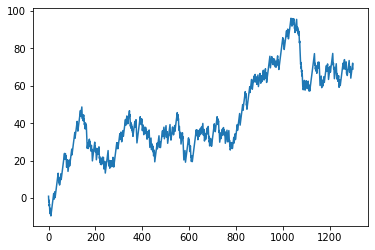

In [10]:
#Differences in dataset
def cumular(inputs):
    differentials = []
    tot = 0
    for i in range(len(inputs) - 1):
        tot += inputs[i]
        differentials.append(tot)
    return differentials

input_data = cumular(data)

plt.plot(input_data)

In [11]:
# df = pd.DataFrame({'Train Data': input_data})
# df.head()
# train_data = df
# train_set = train_data.iloc[:,0:1].values
# sc = MinMaxScaler(feature_range = (0, 1))
# training_set_scaled = sc.fit_transform(train_set)
input_data = np.array(input_data)
input_data = input_data/np.max(input_data)
input_data = input_data.reshape(1299, 1)
input_data.shape
# training_set_scaled.shape


(1299, 1)

In [12]:
train_data, test_data = input_data[:1000], input_data[1000:]

In [13]:
# train_data.shape, test_data.shape

In [14]:
random.uniform(0, 1)

0.421905934190446

In [33]:
#Generate noise to give model a kind of Brownian motion dynamic

#We assume that given a prediction y_n, the next prediction y_n+1 is going to be a random value along some interval
#the average of which is the ground truth data... we can then use an array of possible values as training data
#to predict the ground truth of unseen time series data in the future!
import random
def gaussian_noise(value, num_noise_pts,sigma=random.uniform(0,1)):
    #sigma = random.uniform(0, 1) #In case we want a volatile variance/std
    return np.random.normal(value, 0.1,(num_noise_pts, value.shape[0])) #standard deviation can be obtained more accu 
# value = u_data[1]                 #by finding covariance matrix of dataset through
value = input_data[1]                                                         #Gaussian process regression techniques.
#Treat the value of interest as the mean of a Gaussian distribution to add stochasticity to the model
noise = gaussian_noise(value, 100)
# value.shape, train_data[1].shape
noise.shape, value.shape, noise.shape, np.mean(noise), input_data[1]
noise

array([[-1.10138241e-01],
       [-1.48087414e-02],
       [ 1.15423847e-01],
       [ 7.67020258e-03],
       [ 1.56857365e-01],
       [ 2.21681919e-01],
       [-6.65541803e-02],
       [-1.48369917e-01],
       [-2.41067399e-02],
       [-2.44144828e-02],
       [-8.03004878e-02],
       [-8.02156413e-02],
       [-6.29993543e-02],
       [ 8.98218206e-02],
       [ 9.43556754e-02],
       [ 5.80758255e-02],
       [-1.45742442e-01],
       [-6.67409922e-02],
       [-7.31431644e-02],
       [-2.42637659e-02],
       [ 1.99906892e-01],
       [-6.98837082e-02],
       [ 2.87530512e-02],
       [-9.01277536e-02],
       [ 8.03025087e-02],
       [-1.30524222e-01],
       [ 1.08749915e-01],
       [ 9.03050821e-02],
       [-7.11790765e-02],
       [ 6.37213891e-02],
       [-4.79526261e-02],
       [-4.45966943e-02],
       [-3.84332255e-02],
       [-6.55633356e-05],
       [-1.27593512e-01],
       [-1.68500767e-02],
       [-6.62932296e-02],
       [-9.28796268e-02],
       [ 5.5

[]

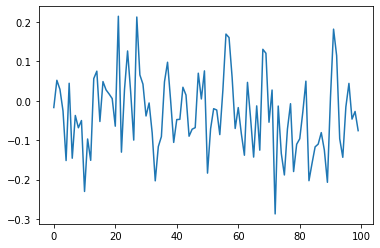

In [16]:
plt.plot(noise)
plt.plot()

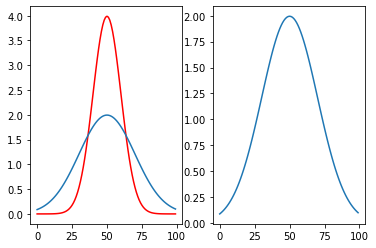

In [17]:
def gaussian_distribution_function(x, mean, sigma):
    normalization_constant = 1/(np.sqrt(2 * np.pi) * sigma)
    return normalization_constant * np.exp(-(x - mean) ** 2 / (2 * sigma ** 2))

Z = np.linspace(0, 0.99, 100)
#Play around with the variance to see how much of the data is encapsulated near the mean based on 
#its 
fig, ax = plt.subplots(1,2)
low_sigma = gaussian_distribution_function(Z, 0.5, 0.1)
high_sigma = gaussian_distribution_function(Z, 0.5, 0.2)

ax[0].plot(low_sigma, color='red')
ax[0].plot(high_sigma)
ax[1].plot(high_sigma)


In [18]:
def preprocess(data_, num_noise_pts):
    X_, y_ = [], []
    for i in range(1,len(data_)):
        X_.append(gaussian_noise(data_[i-1], num_noise_pts, sigma=0.2))
        y_.append(data_[i])
    X_, y_ = np.array(X_), np.array(y_)
    return X_, y_

# X_train, y_train = preprocess(input_data[:1000], 100)
# X_test, y_test = preprocess(input_data[1000:], 100)
X, y = preprocess(input_data, 100, )
X = X/np.max(X)
y = y/np.max(y)
X.shape, y.shape

((1298, 100, 1), (1298, 1))

In [19]:
X_train, y_train = X[:1000], y[:1000]
X_test, y_test = X[1000:], y[1000:]

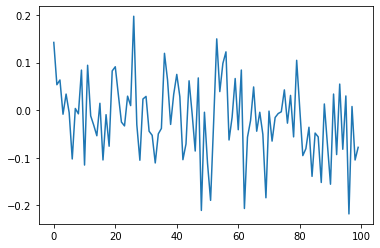

In [20]:
plt.plot(X_train[1])

In [21]:
X_test.shape, X_train.shape

((298, 100, 1), (1000, 100, 1))

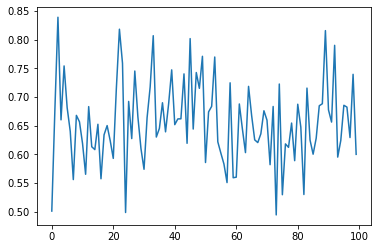

In [22]:
plt.plot(X_test[1])

In [23]:
np.max(X_train), np.max(X_test)

(0.9092124473909947, 1.0)

In [24]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1000, 100, 1), (1000, 1), (298, 100, 1), (298, 1))

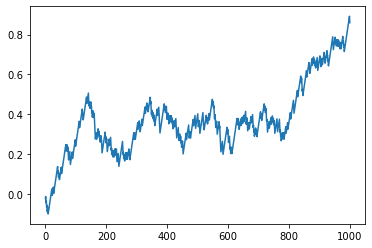

In [25]:
plt.plot(y_train)

In [26]:
X_test.shape, X_train.shape, y_train.shape

((298, 100, 1), (1000, 100, 1), (1000, 1))

In [27]:
X_train.shape

(1000, 100, 1)

In [28]:
model = Sequential()
model.add(LSTM(units=100, return_sequences=True,input_shape=X_train.shape[1:]))
model.add(Dropout(0.2))
model.add(LSTM(150, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(150, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(150, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(150, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(150))
model.add(Dropout(0.2))
model.add(Dense(1))

2022-09-23 19:35:02.387475: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-23 19:35:02.387519: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-23 19:35:02.387550: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dolan-VivoBook-ASUSLaptop-X509DAP-M509DA): /proc/driver/nvidia/version does not exist
2022-09-23 19:35:02.408109: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [29]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 100)          40800     
                                                                 
 dropout (Dropout)           (None, 100, 100)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 150)          150600    
                                                                 
 dropout_1 (Dropout)         (None, 100, 150)          0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 150)          180600    
                                                                 
 dropout_2 (Dropout)         (None, 100, 150)          0         
                                                                 
 lstm_3 (LSTM)               (None, 100, 150)          1

In [31]:
history = model.fit(X_train,
                 y_train,
                 epochs = 10, 
                 batch_size = 32,
                 validation_data = (X_test, y_test),
 )

Epoch 1/10
32/32 [==============================] - 49s 1s/step - loss: 0.0955 - val_loss: 0.0307
Epoch 2/10
28/32 [=========================>....] - ETA: 3s - loss: 0.0084

KeyboardInterrupt: 

In [28]:
# for i in range(10):
#     input_x = np.expand_dims(X_train, axis=0)
#     input_y = np.expand_dims(y_train, axis=0)  
#     model.fit(input_x, input_y,
#                  epochs = 10, 
#                  batch_size = 32,)

Epoch 1/10


2022-09-18 11:59:11.051120: W tensorflow/core/common_runtime/forward_type_inference.cc:231] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_BOOL
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_LEGACY_VARIANT
    }
  }
}

	while inferring type of node 'mean_squared_error/cond/output/_11'
2022-09-18 11:59:13.986952: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at transpose_op.cc:142 : INVALID_ARGUMENT: transpose expects a vector of size 4. But input(1) is a vector of size 3


InvalidArgumentError: Graph execution error:

transpose expects a vector of size 4. But input(1) is a vector of size 3
	 [[{{node transpose_0}}]]
	 [[sequential/lstm/PartitionedCall]] [Op:__inference_train_function_24821]

In [24]:
predictions = model.predict(X_test)

10/10 [==============================] - 7s 271ms/step


In [25]:
predictions

array([[0.47613326],
       [0.48666993],
       [0.49450156],
       [0.52771187],
       [0.51160806],
       [0.532056  ],
       [0.55575985],
       [0.5301445 ],
       [0.5782194 ],
       [0.602708  ],
       [0.5833057 ],
       [0.59902406],
       [0.6000429 ],
       [0.5806157 ],
       [0.5945793 ],
       [0.5876211 ],
       [0.5856949 ],
       [0.62947434],
       [0.6436407 ],
       [0.6283006 ],
       [0.6417289 ],
       [0.65474117],
       [0.6964647 ],
       [0.6629885 ],
       [0.6012541 ],
       [0.6214526 ],
       [0.633005  ],
       [0.6197501 ],
       [0.581477  ],
       [0.57253176],
       [0.5902316 ],
       [0.5807593 ],
       [0.58921874],
       [0.6244616 ],
       [0.6604639 ],
       [0.6043653 ],
       [0.64320916],
       [0.65749496],
       [0.6581394 ],
       [0.6819884 ],
       [0.68364847],
       [0.7028415 ],
       [0.7146272 ],
       [0.6850235 ],
       [0.6362241 ],
       [0.63106364],
       [0.61267555],
       [0.636

In [26]:
len(X_test)

298

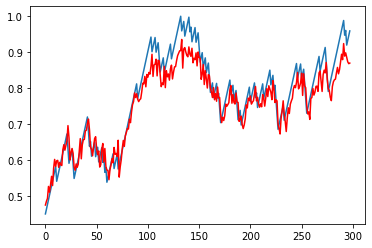

In [27]:
#NEW FINDING: It seems that by doubling the standard deviation of our Gaussians from 0.1 to 0.2 in our training 


# data (i.e. generating wider distributions with a more uniform probability density) the model trained 

#actually almost perfectly fit to the test data after only 10 epochs training in this case!

Z = np.linspace(0, len(y_test)-1, len(y_test))
y_test /= np.max(y_test)
plt.plot(Z, y_test)
plt.plot(Z, predictions, color='red')

In [29]:
predict_on_train = model.predict(X_train)

32/32 [==============================] - 9s 275ms/step


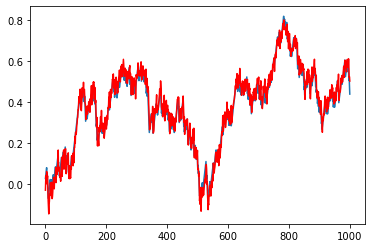

In [30]:
W = np.linspace(0, len(y_train)-1, len(y_train))
plt.plot(W, y_train)
plt.plot(W, predict_on_train,color='red')

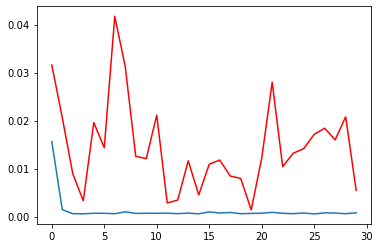

In [145]:
m = len(history.history['loss'])
M = np.linspace(0, m-1, m)
plt.plot(M, history.history['loss'])
plt.plot(M, history.history['val_loss'], color='red')

0.1590921365907716 0.06592368419568784


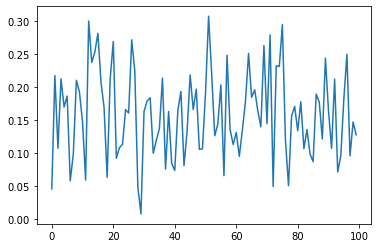

In [147]:
print(np.mean(X_test[5]), np.std(X_test[5]))
plt.plot(X_test[5])

0.4970819987958994 0.07280194990449228


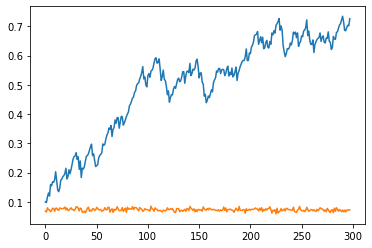

In [148]:
means, variances = [], []

for j in range(len(X_test)):
    means.append(np.mean(X_test[j]))
    variances.append(np.std(X_test[j]))
print(np.mean(means), np.mean(variances))
plt.plot(means)
plt.plot(variances)

#This means that we could model the mean of every point in the dataset as a random variable
#itself. This gives us a way of modelling additional training data as a function of time 

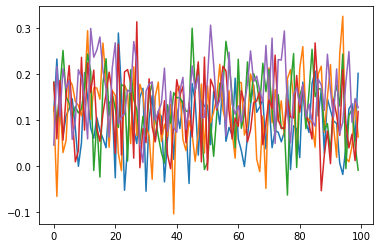

In [149]:
plt.plot(X_test[1])
plt.plot(X_test[2])
plt.plot(X_test[3])
plt.plot(X_test[4])
plt.plot(X_test[5])

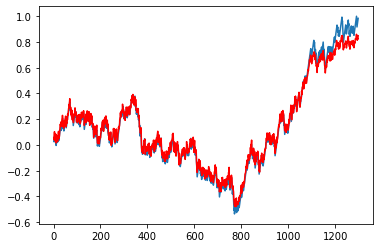

In [150]:
V = np.linspace(0, len(input_data)-1, len(input_data))

total_ground_truth = y_train.tolist() + y_test.tolist()
total_predictions = predict_on_train.tolist() + predictions.tolist()

plt.plot(V[1:], total_ground_truth)
plt.plot(V[1:], total_predictions, color='red')
#Training a recurrent neural network on past data plus noise guarantees some interesting accuracy...

In [151]:
model.save('/home/dolan/Desktop/DataScience/selfdriving/StochasticLSTM.h5')

In [100]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

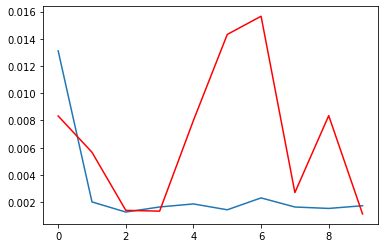

In [101]:
EPOCHS = np.linspace(0, len(training_loss)-1, len(training_loss))
plt.plot(EPOCHS, training_loss)
plt.plot(EPOCHS, validation_loss, color='red')

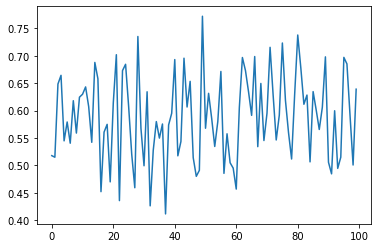

In [104]:
plt.plot(X_test[1])
X_1 = np.expand_dims(X_test[1], axis=0)

In [105]:
pred1 = model.predict(X_1)

1/1 [==============================] - 0s 138ms/step


# Bitcoin price predictor 

In [62]:
PATH = '/media/dolan/Backup Plus/Financial/archive/coin_Bitcoin.csv'

btc = pd.read_csv(PATH)

In [63]:
btc.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


In [125]:
data = btc['High']
X_btc = btc.drop(['Name', 'Symbol', 'SNo', 'Date'], axis=1).values

In [126]:
data = data.values
data = data.reshape(len(data),1)
data.shape, X_btc.shape

((2991, 1), (2991, 6))

In [127]:
data

array([[  147.48800659],
       [  146.92999268],
       [  139.88999939],
       ...,
       [35937.56714724],
       [35284.34443007],
       [35038.53636342]])

In [128]:
X_btc = X_btc.reshape(len(X_btc), 6)

In [129]:
X_btc_train, y_btc_train = X_btc[:2000], data[:2000]
X_btc_test, y_btc_test = X_btc[2000:], data[2000:]

In [132]:
X_btc_train = X_btc_train.reshape(2000, 6, 1)

In [133]:
crypto = Sequential()
crypto.add(LSTM(units=100, return_sequences=True, input_shape=X_btc_train.shape[1:]))
crypto.add(Dropout(0.2))
crypto.add(LSTM(150, return_sequences=True))
crypto.add(Dropout(0.2))
crypto.add(LSTM(150, return_sequences=True))
crypto.add(Dropout(0.2))
crypto.add(LSTM(150, return_sequences=True))
crypto.add(Dropout(0.2))
crypto.add(LSTM(150, return_sequences=True))
crypto.add(Dropout(0.2))
crypto.add(Dense(1))

In [134]:
crypto.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [136]:
hist = model.fit(X_btc_train, y_btc_train, epochs=15, batch_size=64, validation_split=0.2)

Epoch 1/15


ValueError: in user code:

    File "/home/dolan/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/home/dolan/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/dolan/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "/home/dolan/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 891, in train_step
        self._validate_target_and_loss(y, loss)
    File "/home/dolan/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 848, in _validate_target_and_loss
        raise ValueError(

    ValueError: Target data is missing. Your model was compiled with loss=mean_squared_error, and therefore expects target data to be provided in `fit()`.


# 2D Model

In [58]:
fwd = np.zeros(800) + random.uniform(0,2)
bwd = np.zeros(500) - random.uniform(0,2)

right = np.zeros(800) + random.uniform(0,2)
left = np.zeros(500) - random.uniform(0,2)


#Let u-coordinate be forward, v is sideways

u = fwd.tolist() + bwd.tolist()
v = right.tolist() + left.tolist()

random.shuffle(u)
random.shuffle(v)
print(len(u), len(v))


1300 1300


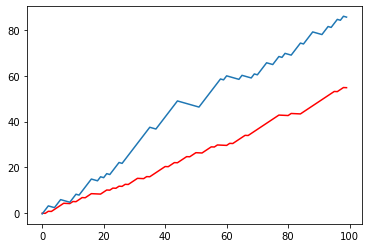

In [59]:
#Differences in dataset
def cumular(inputs):
    differentials = []
    tot = 0
    for i in range(len(inputs) - 1):
        tot += inputs[i]
        differentials.append(tot)
    return differentials

u_data = cumular(u)
v_data = cumular(v)
plt.plot(u_data[:100], color='red')
plt.plot(v_data[:100])

In [60]:
user_inputs = []

for j in range(len(u_data)):
    
    user_inputs.append([u_data[j], v_data[j]])

In [61]:
# print('Our neural network will generate outputs just like this!')
# print('Forward/Backward: ', user_inputs[0][0], 'Right/left: ', user_inputs[0][1])
u_data, v_data = np.array(u_data), np.array(v_data)
u_data, v_data = u_data/np.max(u_data), v_data/np.max(v_data)
u_data, v_data = u_data.reshape(len(u_data), 1), v_data.reshape(len(v_data), 1)
u_data.shape, v_data.shape

((1299, 1), (1299, 1))

In [62]:
user_inputs = np.array(user_inputs)
user_inputs = user_inputs/np.max(user_inputs)
# input_data = np.array(input_data)
# input_data = input_data/np.max(input_data)
# input_data = input_data.reshape(1299, 1)
# input_data.shape

In [4]:
import random
def gaussian_noise(value, num_noise_pts, sigma=random.uniform(0,1)):
    sigma = random.uniform(0, 1) 
    return np.random.normal(value, sigma,(num_noise_pts, value.shape[0])) #standard deviation can be obtained more accu 
# noise_2d = gaussian_noise(user_inputs[1], 100)
print('Noisy data indicating range of possible outcomes centred around ground truth value')
# noise_2d.shape, noise_2d

u_noise = gaussian_noise(u_data[1], 100)
v_noise = gaussian_noise(v_data[1], 100)

# u_data[1], user_inputs[1], user_inputs.shape
u_noise.shape, v_noise.shape, u_noise, 

Noisy data indicating range of possible outcomes centred around ground truth value


NameError: name 'u_data' is not defined

In [64]:
gaussian_noise(u_data[1], 10)

array([[ 0.03319977],
       [-0.00318909],
       [ 0.03892597],
       [ 0.03830433],
       [-0.03201762],
       [ 0.00292567],
       [-0.01933868],
       [ 0.00129378],
       [ 0.04553695],
       [ 0.0526193 ]])

In [65]:
def preprocess(data_, num_noise_pts):
    X_, y_ = [], []
    for i in range(1,len(data_)):
        X_.append(gaussian_noise(data_[i-1], num_noise_pts))
        y_.append(data_[i][0])
    X_, y_ = np.array(X_), np.array(y_)
    X_ = X_/np.max(X_)
    y_ = y_/np.max(y_)
    return X_, y_

X_u, y_u = preprocess(u_data, 100)
X_v, y_v = preprocess(v_data, 100)

# X_u = X_u/np.max(X_u)
# y_u = y_u/np.max(y_u)
# X_v = X_v/np.max(X_v)
# y_v = y_v/np.max(y_v)
X_train_u, X_test_u = X_u[:1000], X_u[1000:]
y_train_u, y_test_u = y_u[:1000], y_u[1000:]


X_train_v, X_test_v = X_v[:1000], X_v[1000:]
y_train_v, y_test_v = y_v[:1000], y_v[1000:]
X_train_u.shape, X_train_v.shape

((1000, 100, 1), (1000, 100, 1))

In [66]:
np.max(X_v), np.max(X_u)

(1.0, 1.0)

In [67]:
# X.shape, y.shape, user_inputs[1][0]
X_u.shape, y_u.shape, X_v.shape, y_v.shape

((1298, 100, 1), (1298,), (1298, 100, 1), (1298,))

In [68]:
X_train_v.shape, X_test_u.shape, X_u[1000:].shape

((1000, 100, 1), (298, 100, 1), (298, 100, 1))

In [69]:

# #vehicle stops or goes.
# from keras.layers import Input, add, Flatten, Activation, Normalization, Dense
# from keras.models import Model 


# #Combined LSTM/Multilayer perceptron architecture. Two LSTM's are simultaneously trained on input data 
# #u_model for forward/backward data and the v_model for right/left turning.
# #The output of each recurrent LSTM model will be a time series prediction for each direction, trained on 
# #noise input data, which is then fed into a dense output layer of two neurons each corresponding to a
# #cumulative net displacement along a given direction, and followed by a relu activation function to 
# #enable backpropagation.The weights of the LSTM's are updated by backpropagation from a common loss function
# #MSE associated with the single hidden layer at the end.

# #This way, both recurrent LSTM's are trained in tandem so that input data into one correlates with output data
# #in the other due to the backpropagation from the same loss layer

# u_model = Sequential()
# u_model.add(LSTM(units=50, return_sequences=True,input_shape=X_train_u.shape[1:]))
# u_model.add(Dropout(0.2))
# u_model.add(LSTM(75, return_sequences=True))
# u_model.add(Dropout(0.2))
# u_model.add(LSTM(75, return_sequences=True))
# u_model.add(Dropout(0.2))
# u_model.add(LSTM(75, return_sequences=True))
# u_model.add(Dropout(0.2))
# u_model.add(LSTM(75, return_sequences=True))
# u_model.add(Dropout(0.2))
# u_model.add(LSTM(75))
# u_model.add(Dropout(0.2))
# u_model.add(Dense(1))

# v_model = Sequential()
# v_model.add(LSTM(units=50, return_sequences=True,input_shape=X_train_v.shape[1:]))
# v_model.add(Dropout(0.2))
# v_model.add(LSTM(75, return_sequences=True))
# v_model.add(Dropout(0.2))
# v_model.add(LSTM(75, return_sequences=True))
# v_model.add(Dropout(0.2))
# v_model.add(LSTM(75, return_sequences=True))
# v_model.add(Dropout(0.2))
# v_model.add(LSTM(75, return_sequences=True))
# v_model.add(Dropout(0.2))
# v_model.add(LSTM(75))
# v_model.add(Dropout(0.2))
# v_model.add(Dense(1))



# # merged_output = add([u_model.output, v_model.output])   

# driver = Sequential()
# # driver.add(Normalization())
# # driver.add(Dense(10, activation='relu'))
# # driver.add(Dropout(0.2))
# driver.add(Dense(2))

# driver = Model([u_model.input, v_model.input], driver(merged_output))


# driver.compile(optimizer='adam',loss = 'mean_squared_error')

# driver_history = driver.fit(
#                     [X_train_u, X_train_v],
#                     [y_train_u, y_train_v],
#                     epochs = 50, 
#                     batch_size = 32,
#                     validation_split=0.2
# )


In [70]:
u_model = Sequential()
u_model.add(LSTM(units=50, return_sequences=True,input_shape=X_train_u.shape[1:]))
u_model.add(Dropout(0.2))
u_model.add(LSTM(75, return_sequences=True))
u_model.add(Dropout(0.2))
u_model.add(LSTM(75, return_sequences=True))
u_model.add(Dropout(0.2))
u_model.add(LSTM(75, return_sequences=True))
u_model.add(Dropout(0.2))
u_model.add(LSTM(75, return_sequences=True))
u_model.add(Dropout(0.2))
u_model.add(LSTM(75))
u_model.add(Dropout(0.2))
u_model.add(Dense(1))



In [71]:
#Reshape to get axes for horizontal and vertical motion
preds_test = predictions_test.reshape(predictions_test.shape[1], predictions_test.shape[0])
preds_train = predictions_train.reshape(predictions_train.shape[1], predictions_train.shape[0])

NameError: name 'predictions_test' is not defined

In [72]:
W = np.linspace(0, 298, 299)

In [134]:
L = np.linspace(0, 1298, 1299)
total_prediction_u = preds_train[0].tolist() + preds_test[0].tolist()
total_prediction_v = preds_train[1].tolist() + preds_test[1].tolist()

y_total_v = y_train_v.tolist() + y_test_v.tolist()
#For each window of time-series-data, calculate the average y-value of the curve and set it as the threshold
#Graphical predictions from joint neural network
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.plot(W, preds[0])
ax1.plot(W, y_test_v)
ax2.plot(W, preds[1], color='red')
ax2.plot(W, y_test_u)

ax3.plot(L, total_prediction_v, color='red')
ax3.plot(L, y_total_v)
# plt.plot(W, preds[1], color='red')
# predictions
# plt.plot(W, predictions[:][1])

NameError: name 'preds_train' is not defined

In [135]:
#Calculate velocity from position time graph by taking derivative of position data

def velocity(y):
    derivative = [0]
    for i in range(len(y)):
        dy = y[i] - y[i - 1]
        derivative.append(dy)
    return np.array(derivative)


u_velocity = velocity(u_preds.reshape(299,[0])
u_velocity.shape, W.shape
plt.plot(W, u_velocity)
plt.scatter(W, u_velocity, color='red')

SyntaxError: invalid syntax (3573717717.py, line 12)

In [73]:
u_model.compile(optimizer = 'adam', loss = 'mean_squared_error')


In [74]:
#Pretrain both models in advance, then join them using a merge
u_history = u_model.fit(
         X_u,
         y_u,
         epochs = 10, 
         batch_size = 32,
         validation_data=(X_test_u, y_test_u),
                   )

Epoch 1/10
41/41 [==============================] - 32s 440ms/step - loss: 0.0827 - val_loss: 0.0157
Epoch 2/10
41/41 [==============================] - 14s 353ms/step - loss: 0.0109 - val_loss: 0.0201
Epoch 3/10
41/41 [==============================] - 15s 354ms/step - loss: 0.0091 - val_loss: 0.0048
Epoch 4/10
41/41 [==============================] - 15s 355ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 5/10
41/41 [==============================] - 15s 356ms/step - loss: 0.0077 - val_loss: 0.0033
Epoch 6/10
41/41 [==============================] - 15s 358ms/step - loss: 0.0066 - val_loss: 0.0062
Epoch 7/10
41/41 [==============================] - 15s 356ms/step - loss: 0.0078 - val_loss: 0.0056
Epoch 8/10
41/41 [==============================] - 15s 355ms/step - loss: 0.0063 - val_loss: 0.0036
Epoch 9/10
41/41 [==============================] - 15s 358ms/step - loss: 0.0059 - val_loss: 0.0050
Epoch 10/10
41/41 [==============================] - 15s 358ms/step - loss: 0.0063 - val_lo

In [76]:
v_model = Sequential()
v_model.add(LSTM(units=50, return_sequences=True,input_shape=X_train_v.shape[1:]))
v_model.add(Dropout(0.2))
v_model.add(LSTM(75, return_sequences=True))
v_model.add(Dropout(0.2))
v_model.add(LSTM(75, return_sequences=True))
v_model.add(Dropout(0.2))
v_model.add(LSTM(75, return_sequences=True))
v_model.add(Dropout(0.2))
v_model.add(LSTM(75, return_sequences=True))
v_model.add(Dropout(0.2))
v_model.add(LSTM(75))
v_model.add(Dropout(0.2))
v_model.add(Dense(1))

v_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [77]:
v_history = v_model.fit(
         X_v,
         y_v,
         epochs = 10, 
         batch_size = 32,
         validation_data=(X_test_v, y_test_v),
                   )

Epoch 1/10
41/41 [==============================] - 32s 468ms/step - loss: 0.0780 - val_loss: 0.0334
Epoch 2/10
41/41 [==============================] - 18s 440ms/step - loss: 0.0127 - val_loss: 0.0087
Epoch 3/10
41/41 [==============================] - 17s 405ms/step - loss: 0.0097 - val_loss: 0.0073
Epoch 4/10
41/41 [==============================] - 16s 393ms/step - loss: 0.0093 - val_loss: 0.0037
Epoch 5/10
41/41 [==============================] - 16s 390ms/step - loss: 0.0073 - val_loss: 0.0042
Epoch 6/10
41/41 [==============================] - 15s 375ms/step - loss: 0.0070 - val_loss: 0.0030
Epoch 7/10
41/41 [==============================] - 15s 372ms/step - loss: 0.0074 - val_loss: 0.0029
Epoch 8/10
41/41 [==============================] - 15s 369ms/step - loss: 0.0064 - val_loss: 0.0096
Epoch 9/10
41/41 [==============================] - 15s 368ms/step - loss: 0.0061 - val_loss: 0.0029
Epoch 10/10
41/41 [==============================] - 16s 393ms/step - loss: 0.0063 - val_lo

In [79]:
X_train_v.shape, X_test_v.shape, y_train_v.shape

((1000, 100, 1), (298, 100, 1), (1000,))

In [80]:
np.max(X_train_v), np.max(y_train_v), np.max(X_train_u), np.max(y_train_u)

(1.0, 0.7728807586681358, 0.887399827295446, 0.7896396698306969)

In [81]:
u_preds = u_model.predict(X_test_u)
v_preds = v_model.predict(X_test_v)

10/10 [==============================] - 5s 108ms/step


In [82]:
u_preds.shape

(298, 1)

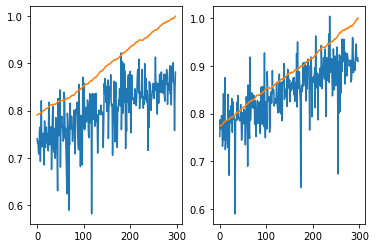

In [83]:
fig, (ax1, ax2) = plt.subplots(1,2)
W = np.linspace(0, 297, 298)
ax1.plot(W, u_preds)
ax1.plot(W, y_test_u)

ax2.plot(W, v_preds)
ax2.plot(W, y_test_v)

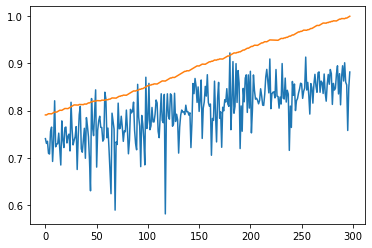

In [85]:
plt.plot(W, u_preds)
plt.plot(W, y_test_u)

In [101]:
x = u_preds.reshape(1,299)
z = v_preds.reshape(1,299)

Text(0.5, 0.5, 'Y')

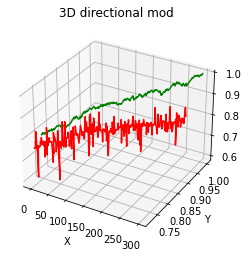

In [160]:
from mpl_toolkits import mplot3d  
fig = plt.figure() 
  
# syntax for 3-D projection 
ax = plt.axes(projection ='3d') 

x = np.linspace(0,298,299) 

 
y = y_test_u
z = y_test_v
  
    
y_preds = u_preds.reshape(299)
z_preds = v_preds.reshape(299)
# plotting 
ax.plot3D(x, y, z, 'green') 
ax.plot3D(x, y_preds, z_preds, 'red') 

ax.set_title('3D directional mod') 
plt.xlabel('X')
plt.ylabel('Y')

# https://machinelearningmastery.com/update-lstm-networks-training-time-series-forecasting/

In [127]:
driver_preds[1]
# plt.plot(W, driver_preds[0])
# plt.plot(W, driver_preds[1])

array([1.4461656], dtype=float32)

In [115]:
y_test_u.shape, u_preds.sha

((299,), (299, 1))

### Softmax approach- take in a set of keylogger values, and one-hot encode training data as 
###
### X_train = Gaussian distribution centered around an index value 
### y_train = one-hot-encoded vector 

In [ ]:
from pynput.keyboard import Key, Listener
import logging

log_dir = ""

logging.basicConfig(filename=(log_dir + "keylog.txt"), level = logging.DEBUG, format = '%(asctime)s: %(message)s:')
def onPress(key):
    logging.info(str(key))
    #if key == Key.esc:
    # return false
with Listener(on_press = onPress) as listener:
    listener.join() 
    #listener.append()  


In [78]:
PATH

NameError: name 'PATH' is not defined

In [ ]:
#Train both models in real time using multithreading.